# Import libraries

In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from mutagen.mp3 import MP3

import IPython
import IPython.display as ipd

import librosa
import librosa.display

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [10]:
parent_path = r'E:\Project\IRS\Dataset'

Language          : Assamese
Total audio files : 965


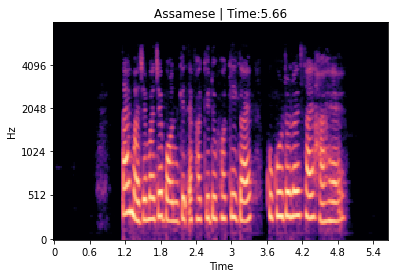

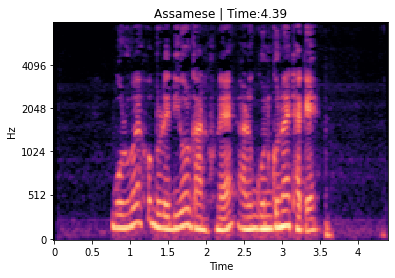

Language          : English
Total audio files : 677020


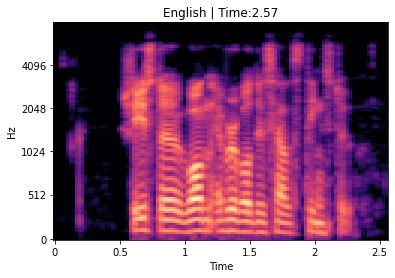

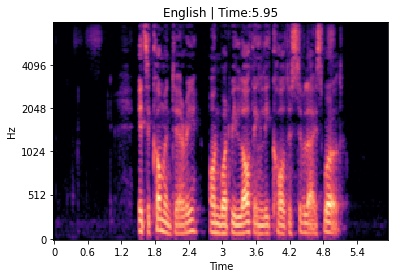

Language          : Hindi
Total audio files : 12784


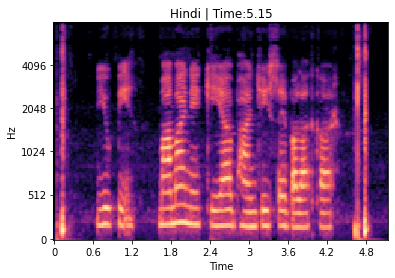

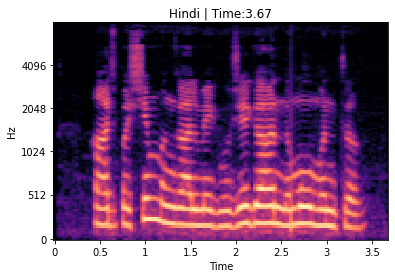

Language          : Malayalam
Total audio files : 2228


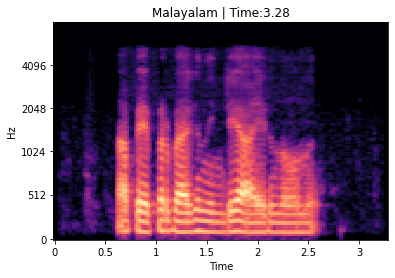

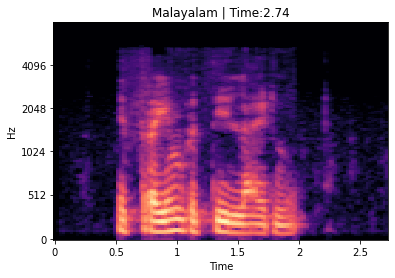

Language          : Marathi
Total audio files : 3149


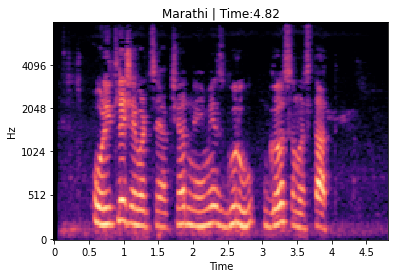

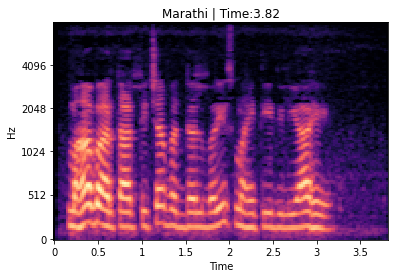

Language          : Odia
Total audio files : 6395


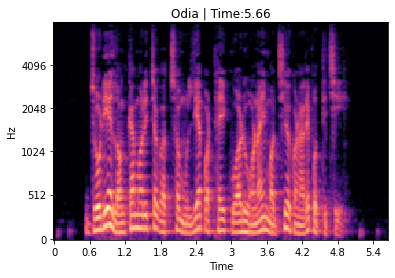

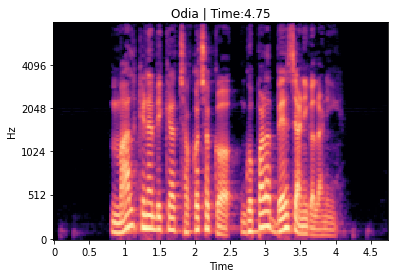

Language          : Punjabi
Total audio files : 2514


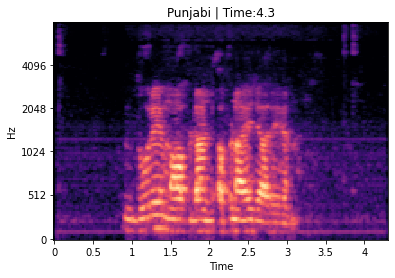

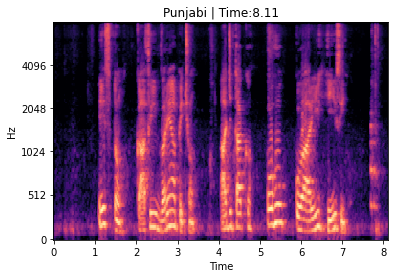

Language          : Urdu
Total audio files : 2920


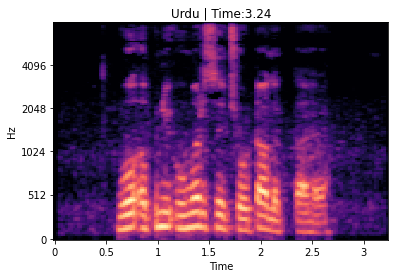

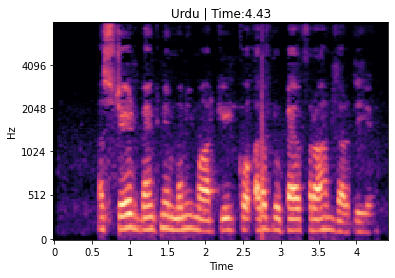

In [84]:
# Mel-spectrogram

for language in os.listdir(parent_path):
    
    files = glob.glob('{}/*.mp3'.format(os.path.join(parent_path, language, 'clips')))
    
    print(f'Language          : {language}')
    print(f'Total audio files : {len(files)}')
    
    sample = random.sample(files,2)
    
    for s in sample:
        IPython.display.display(ipd.Audio(s))
        y, sr = librosa.load(s)   
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmax=8000)
        plt.title(f'{language} | Time:{round(librosa.get_duration(y), 2)}')
        plt.show()
    
    print('='*60)

### Observations:

1) Couple of the languages have large number of audio files.

2) All the audio files are with different duration.

# Data Preparation

In [21]:
files_list = []
lang_list = []

for language in os.listdir(parent_path):
    
    files = glob.glob('{}/*.mp3'.format(os.path.join(parent_path, language, 'clips')))
    
    # We have taken maximum of 2000 audio files from each subfolder
    if len(files)>2000:
        files_list.append(random.sample(files, 2000))
        lang_list.append([language]*2000)
    
    else:
        files_list.append(files)
        lang_list.append([language]*len(files))

In [22]:
data = pd.DataFrame()

for i,j in zip(files_list, lang_list):
    data = data.append(pd.DataFrame({'files':i, 'language':j}))
    
data.head()

,files,language
0,E:\Project\IRS\Dataset\Assamese\clips\common_v...,Assamese
1,E:\Project\IRS\Dataset\Assamese\clips\common_v...,Assamese
2,E:\Project\IRS\Dataset\Assamese\clips\common_v...,Assamese
3,E:\Project\IRS\Dataset\Assamese\clips\common_v...,Assamese
4,E:\Project\IRS\Dataset\Assamese\clips\common_v...,Assamese


In [33]:
# We we'll remove all the audio files with less than 4 sec duration.

def filter_data(row):
    
    try:
        if MP3(row['files']).info.length < 4.0:
            row['files'] = np.nan
    except:
        pass
        
    return row

data = data.apply(lambda x: filter_data(x), axis=1)

na_values = data.isna().sum().sum()

if na_values > 0:
    
    print(f'There are total {na_values} null values.')
    data_wo_na = data.dropna()
    data_wo_na = data_wo_na.sample(frac=1.0, random_state=21).reset_index(drop=True)
    data_wo_na.head()

There are total 5792 null values.


# Feature Extraction

In [35]:
features_extract = False

if features_extract:

    header = ['filename','chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff','zero_crossing_rate','mfcc1',
              'mfcc2','mfcc3','mfcc4','mfcc5','mfcc6','mfcc7','mfcc8','mfcc9','mfcc10','mfcc11','mfcc12','mfcc13','mfcc14',
              'mfcc15','mfcc16','mfcc17','mfcc18','mfcc19','mfcc20','label']

    features = pd.DataFrame(columns=header)

    for idx, filename in tqdm(data_wo_na.iterrows()):

        try:

            y, sr = librosa.load(filename['files'], mono=True, duration=4)
            
            # Remove silence at the beginning and end in a file
            y, index = librosa.effects.trim(y)

            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)

            to_append = f'{filename.files} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {filename.language}'

            features = features.append(dict(zip(header, to_append.split())), ignore_index=True)

        except e:
            print(e)
            
    features.to_csv('features.csv', index=False)